<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#Analysis-of-full-length-PacBio-sequencing-of-influenza-mRNAs" data-toc-modified-id="Analysis-of-full-length-PacBio-sequencing-of-influenza-mRNAs-1">Analysis of full-length PacBio sequencing of influenza mRNAs</a></span><ul class="toc-item"><li><span><a href="#Set-up-for-analysis" data-toc-modified-id="Set-up-for-analysis-1.1">Set up for analysis</a></span><ul class="toc-item"><li><span><a href="#Import-Python-modules" data-toc-modified-id="Import-Python-modules-1.1.1">Import Python modules</a></span></li><li><span><a href="#Define-/-create-directories" data-toc-modified-id="Define-/-create-directories-1.1.2">Define / create directories</a></span></li><li><span><a href="#How-many-CPUs-to-use" data-toc-modified-id="How-many-CPUs-to-use-1.1.3">How many CPUs to use</a></span></li></ul></li><li><span><a href="#Get-subreads-files-for-each-sequencing-run" data-toc-modified-id="Get-subreads-files-for-each-sequencing-run-1.2">Get subreads files for each sequencing run</a></span></li><li><span><a href="#Build-circular-consensus-sequences" data-toc-modified-id="Build-circular-consensus-sequences-1.3">Build circular consensus sequences</a></span></li><li><span><a href="#Identify-barcodes" data-toc-modified-id="Identify-barcodes-1.4">Identify barcodes</a></span></li></ul></li></ul></div>

# Analysis of full-length PacBio sequencing of influenza mRNAs
The material from the 10X libraries for the *IFN_enriched* sample was enriched for viral mRNAs by semi-specific PCR, and then sequenced by PacBio.
Here we analyze those data.

## Set up for analysis
First, we do some things to set up the parameters of the analysis.

### Import Python modules
We import the Python modules used.

Note we use some functions from [dms_tools2](https://jbloomlab.github.io/dms_tools2/).

In [40]:
import os
import glob
import subprocess
import shutil
import multiprocessing

from IPython.display import display, HTML, PNG

import dms_tools2.pacbio
from dms_tools2.ipython_utils import showPDF

ImportError: cannot import name 'PNG'

### Define / create directories
We define the names of key directories for input and output, and create these directories if needed:

In [2]:
# top results directory
resultsdir = './results/'
if not os.path.isdir(resultsdir):
    os.mkdir(resultsdir)

# directory for PacBio results
pacbioresultsdir = os.path.join(resultsdir, 'pacbio')
if not os.path.isdir(pacbioresultsdir):
    os.mkdir(pacbioresultsdir)

### How many CPUs to use
Specify max number to use:

In [37]:
max_cpus = 14 # max number of CPUs to use
ncpus = max(multiprocessing.cpu_count(), max_cpus)

## Get subreads files for each sequencing run
We have multiple sequencing runs:
  - A run from June-8-2017 done at the UW PacBio core. This run used a PacBio RSII machine.
  - A run from December-7-2017 done at the Fred Hutch Genomics core. This run used a PacBio Sequel machine.
  
Note that the material sequenced for these two runs was **not** identical. 
The balance of genes that were mixed differed, as well as the size selection and the way that the libraries were loaded.
Therefore, we do not expect the same balance of different reads in the two runs.

In addition, the data were processed differently.
For the Hutch Genomics Core runs, the data are already processed into a `*.subreads.bam` file, while for UW PacBio core runs it is still in the `*.bas.h5` file.

In [3]:
seqruns = ['2017-06-08', '2017-12-07']

seqdirs = {
        '2017-06-08':'/fh/fast/bloom_j/SR/ngs/pacbio_UW/170608 Pacbio single cell/Emulsion Reaction/ABR_C_MACS.AR_0kb',
        '2017-12-07':'/fh/fast/bloom_j/SR/ngs/pacbio/171207_bloom_j/r54228_20171201_171054/1_A01',
        }

bam_already = {'2017-06-08':False, '2017-12-07':True}

Now we get the `*.subreads.bam` file for each run.
If they already exist (e.g., if data were returned by the Fred Hutch Genomics Core), we just need to get the name of the file.
But if they don't exist (e.g., if data were returned from UW PacBio Core), we need to run the PacBio [bax2bam](https://github.com/PacificBiosciences/bax2bam) software to create the `*subreads.bam` files from the `*.bas.h5` files.

In [4]:
# put or copy subreads into this directory
subreadsdir = os.path.join(pacbioresultsdir, 'subreads')
if not os.path.isdir(subreadsdir):
    os.mkdir(subreadsdir)

# store name of subreads files for each sequencing run
subreads = dict([(seqrun, os.path.join(subreadsdir, seqrun + '.subreads.bam'))
                 for seqrun in seqruns])

# get subreads files
for (seqrun, subreadsfile) in subreads.items():
    print("\nGetting subreads for {0} sequencing run".format(seqrun))
    
    if os.path.isfile(subreadsfile):
        print("Subreads file already exists: {0}".format(subreadsfile))
    
    elif bam_already[seqrun]:
        print("Looking for existing subreads file...")
        filepattern = os.path.join(seqdirs[seqrun], '*.subreads.bam')
        existingfiles = glob.glob(filepattern)
        assert existingfiles, "No file matching expected pattern of {0}".format(filepattern)
        assert len(existingfiles) == 1, "Expected one file, but found multiple:\n{0}".format(
                '\n'.join(existingfiles))
        print("Copying subreads file {0} to {1}...".format(existingfiles[0], subreadsfile))
        shutil.copy(existingfiles[0], subreadsfile)
        shutil.copy(existingfiles[0] + '.pbi', subreadsfile + '.pbi')
        print("Completed copying file.")
    
    else:
        print("Building subreads using `bax2bam` version {0}".format(
                subprocess.check_output(['bax2bam', '--version']).decode('utf-8').strip()))
        baxfiles = []
        for (dpath, dirnames, fnames) in os.walk(seqdirs[seqrun]):
            baxfiles += [os.path.join(dpath, fname) for fname in fnames if fname.endswith('.bax.h5')] 
        assert len(baxfiles) > 0, "found no `*.bax.h5` files"
        print("Will build subreads from the following `*.bax.h5` files:\n\t{0}".format(
                '\n\t'.join(baxfiles)))
        print("Now running `bax2bam`...")
        ! bax2bam \
                {' '.join(['"' + x + '"' for x in baxfiles])} \
                -o {subreadsfile.replace('.subreads.bam', '')} \
                --subread
        print("Completed running `bax2bam` to create {0}".format(subreadsfile))
        assert os.path.isfile(subreadsfile)


Getting subreads for 2017-06-08 sequencing run
Subreads file already exists: ./results/pacbio/subreads/2017-06-08.subreads.bam

Getting subreads for 2017-12-07 sequencing run
Subreads file already exists: ./results/pacbio/subreads/2017-12-07.subreads.bam


## Build circular consensus sequences
We build circular consensus sequences (CCS) using PacBio's algorithm as implemented in the [ccs program](https://github.com/PacificBiosciences/unanimity/blob/develop/doc/PBCCS.md).

We only want reasonably high-quality CCSs.
The [ccs program](https://github.com/PacificBiosciences/unanimity/blob/master/doc/PBCCS.md) provides two ways to control the "accuracy" of reads.
The first is the `--minPasses` option, which corresponds to how many subreads we require to call a circular consensus sequence.
The second is the `--minPredictedAccuracy` option, which provides an explicit estimate of the accuracy.
We will further post-process the CCSs, so we set reasonably high but not extremely stringent values: 3 passes, and at least 99.9% accuracy:


Running `ccs` for sequencing run 2017-06-08
The `ccs` output already exists, so using that existing output.

Running `ccs` for sequencing run 2017-12-07
The `ccs` output already exists, so using that existing output.

Here are statistics on the `ccs` results:


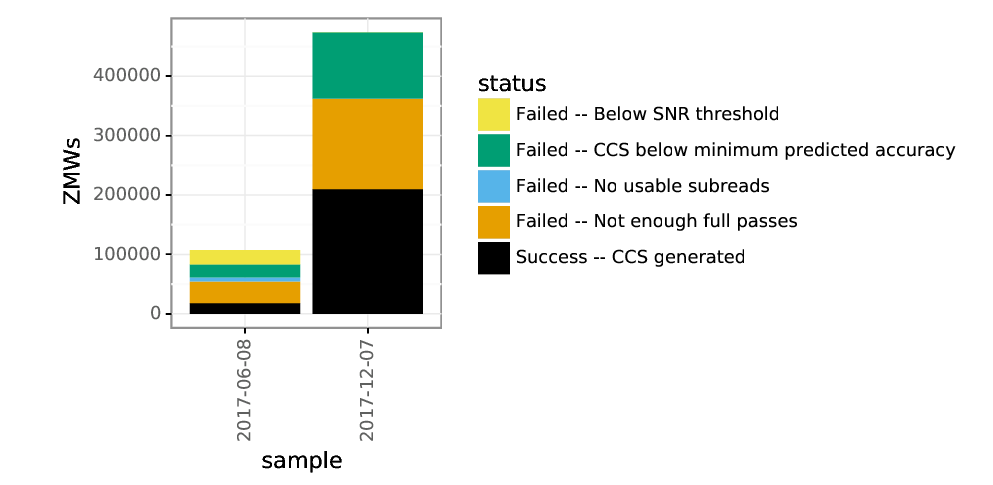

sample,status,number,fraction
2017-12-07,Success -- CCS generated,209930,0.4428
2017-12-07,Failed -- Not enough full passes,152429,0.3215
2017-12-07,Failed -- CCS below minimum predicted accuracy,110974,0.2341
2017-06-08,Failed -- Not enough full passes,36289,0.3371
2017-06-08,Failed -- Below SNR threshold,24052,0.2235
2017-06-08,Failed -- CCS below minimum predicted accuracy,22063,0.2050
2017-06-08,Success -- CCS generated,18063,0.1678
2017-06-08,Failed -- No usable subreads,6810,0.0633


In [38]:
import importlib
importlib.reload(dms_tools2.plot)
importlib.reload(dms_tools2.pacbio)

ccsdir = os.path.join(pacbioresultsdir, 'ccs')
if not os.path.isdir(ccsdir):
    os.mkdir(ccsdir)

ccslist = []
for (seqrun, subreadsfile) in subreads.items():
    print("\nRunning `ccs` for sequencing run {0}".format(seqrun))
        
    reportfile = os.path.join(ccsdir, seqrun + '_report.csv')
    bamfile = os.path.join(ccsdir, seqrun + '_ccs.bam')
    logfile = os.path.join(ccsdir, seqrun + '_log.txt')
        
    if all(map(os.path.isfile, [reportfile, bamfile])):
        print("The `ccs` output already exists, so using that existing output.")
    else:  
        print("Running {0}...".format(
                subprocess.check_output(['ccs', '--version']).decode(
                'utf-8').strip()))
        ! ccs \
            --minLength 50 \
            --maxLength 5000 \
            --minPasses 3 \
            --minPredictedAccuracy 0.999 \
            --logFile {logfile} \
            --reportFile {reportfile} \
            --polish \
            --numThreads {ncpus} \
            {subreadsfile} \
            {bamfile}
        print("Completed `ccs` run.")
        
    ccslist.append(dms_tools2.pacbio.CCS(seqrun, bamfile, reportfile))

print("\nHere are statistics on the `ccs` results:")
zmw_plot = os.path.join(ccsdir, 'ZMW_plot.pdf')
showPDF(zmw_plot)

ccs_report = dms_tools2.pacbio.summarizeCCSreports(
                ccslist, 'zmw', zmw_plot)
display(HTML(ccs_report.query('fraction > 0.005').to_html(index=False)))

Make plots summarizing number of passes, accuracy, and read lengths:

/Users/jbloom/Library/Python/3.6/lib/python/site-packages/matplotlib/tight_layout.py:222: UserWarning: tight_layout : falling back to Agg renderer
  warnings.warn("tight_layout : falling back to Agg renderer")


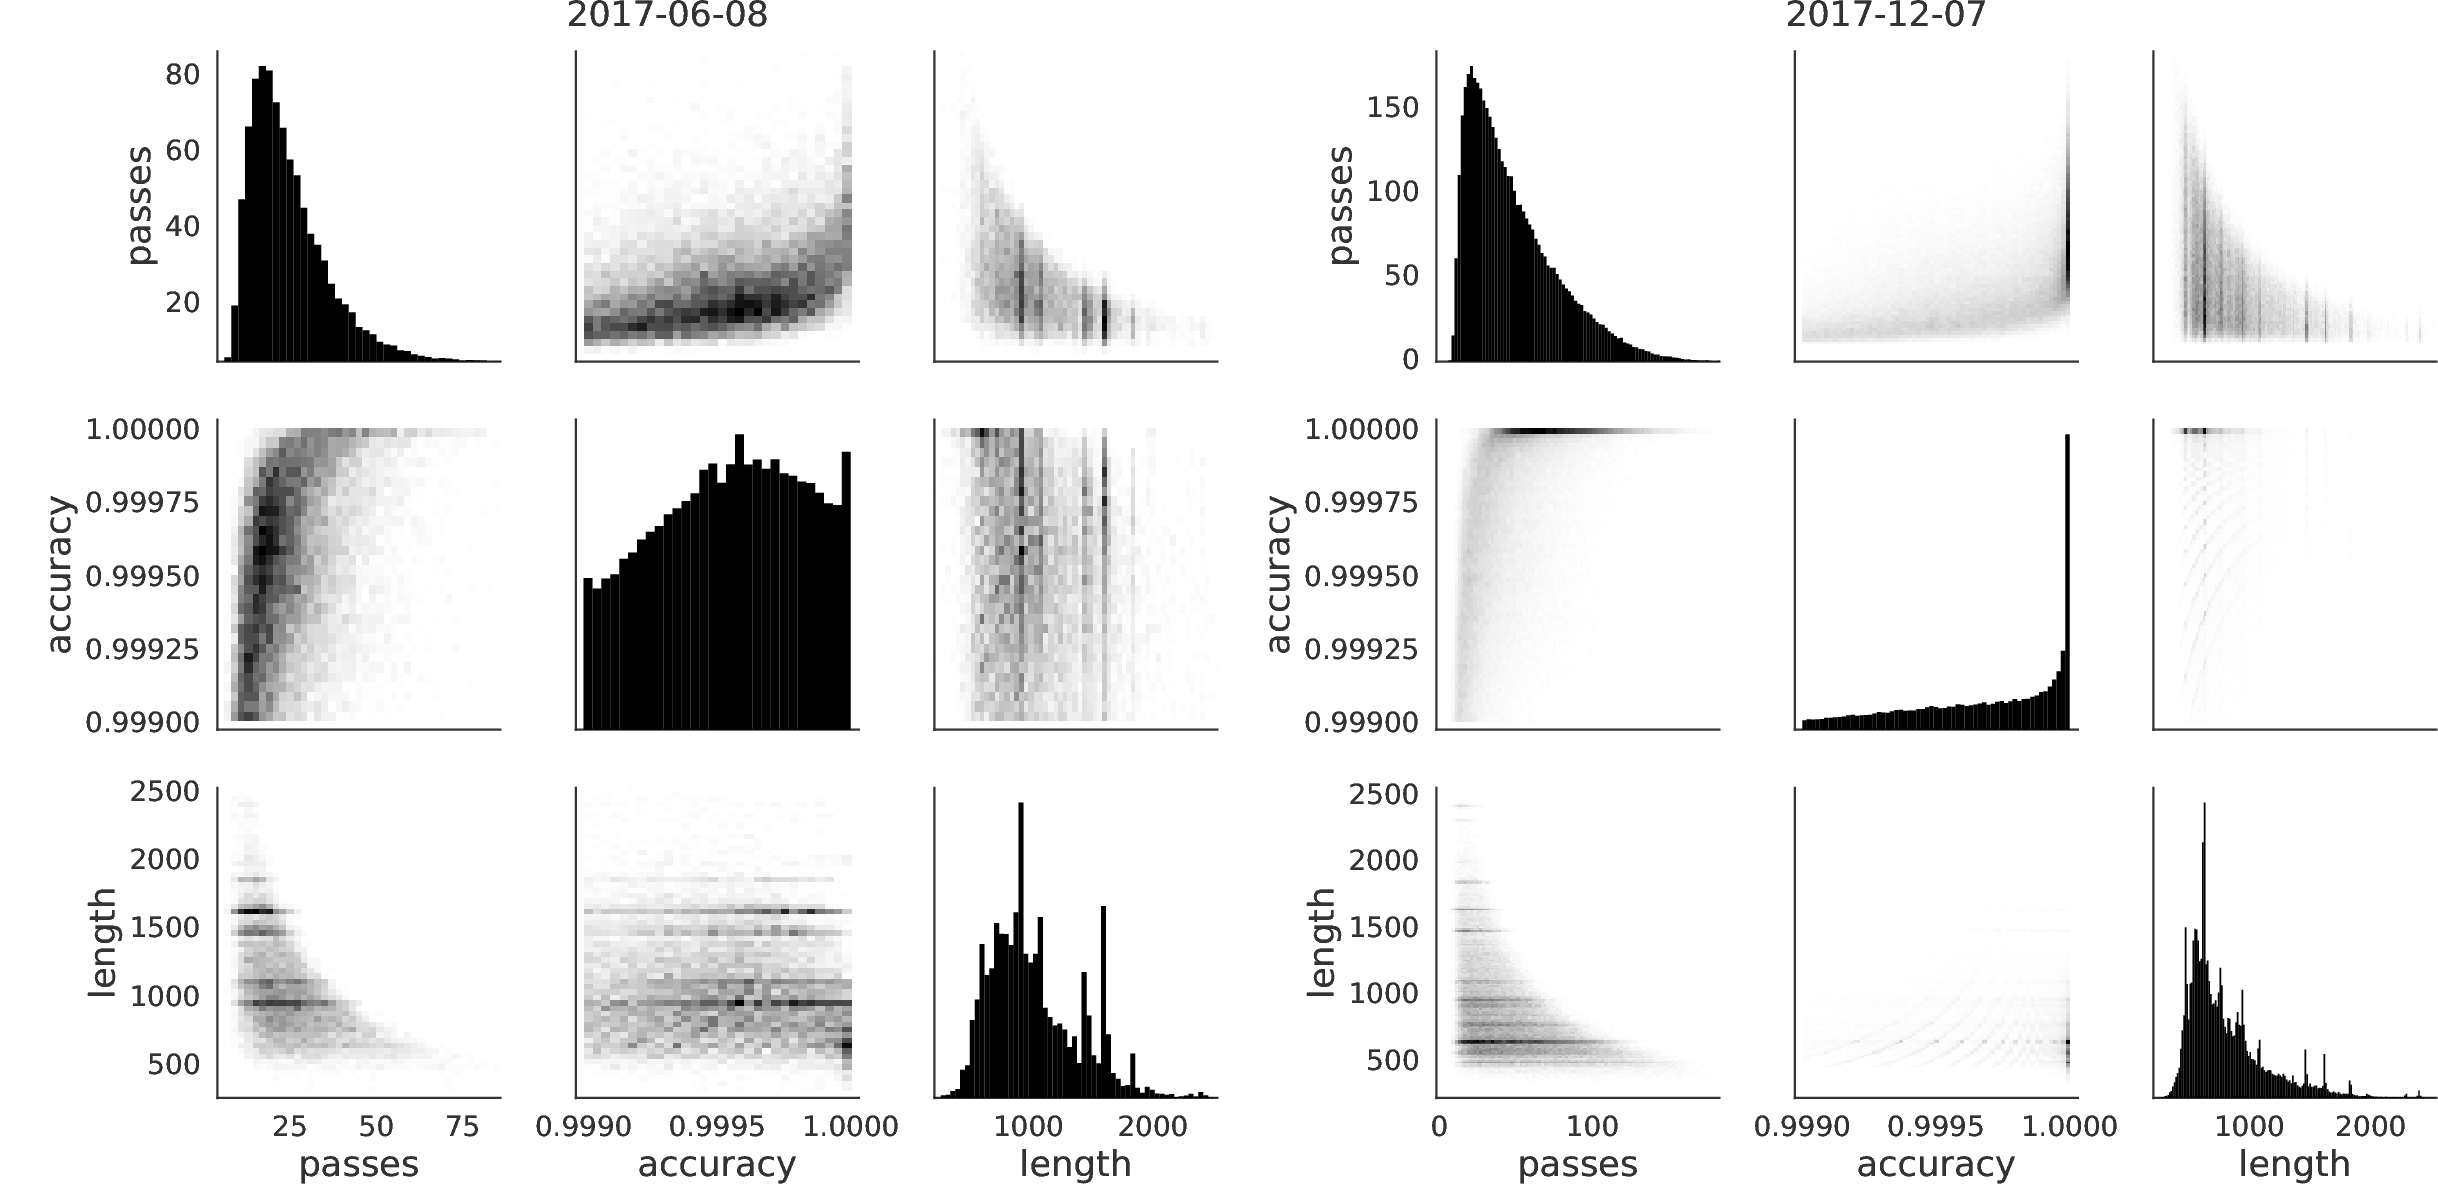

In [22]:
ccs_plots = []
for ccs in ccslist:
    ccs_plots.append(os.path.join(ccsdir, ccs.name + '_CCS_plot.pdf'))
    ccs.plotResults(ccs_plots[-1])
showPDF(ccs_plots)

## Identify barcodes
The PacBio sequencing was performed on PCR-amplified product.

This [10X technical note](https://teichlab.github.io/scg_lib_structs/data/CG000108_AssayConfiguration_SC3v2.pdf) outlines the sequences appended by the v2 10X single-cell 3' kit used in these experiments. 
Specifically:
![./data/images/10Xschematic.png](./data/images/10Xschematic.png)

The Illumina Read 1 Sequencing Primer is [given here (page 41)](https://support.illumina.com/content/dam/illumina-support/documents/documentation/chemistry_documentation/experiment-design/illumina-adapter-sequences-1000000002694-06.pdf) as `ACACTCTTTCCCTACACGACGCTCTTCCGATCT`.